In [17]:
import warnings
warnings.filterwarnings('ignore')

import cftime
import nc_time_axis

import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import cmaps
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats 
import xarray as xr 

from src import utils, models, cesm_utils, plots

%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# List of CESM2 Ensemble Members
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

In [3]:
# Calculate 13-year running correlation between ENSO and MSEA in CESM2
# ENSO: DJF SSTs in Niño3.4 region
# MSEA: MAM prect in MSEA region

# note: cell should take <4s to run
cesm_correlations_list, cesm_msea_prect_anomaly_timeseries_mam_list, cesm_nino34_sst_anomaly_timeseries_djf_list = cesm_utils.process_cesm_runcorr(ensemble_members, window=13)
cesm_correlations_da = xr.concat(cesm_correlations_list, dim='ensemble')

In [4]:
# Concatenate ENSO and MSEA lists into xr.DataArray and select historical (1900-2014) period
cesm_msea_prect_anomaly_timeseries_mam_da = xr.concat(cesm_msea_prect_anomaly_timeseries_mam_list, dim='ensemble')
cesm_nino34_sst_anomaly_timeseries_djf_da = xr.concat(cesm_nino34_sst_anomaly_timeseries_djf_list, dim='ensemble')

cesm_msea_prect_anomaly_timeseries_mam_da_1900_2014 = cesm_msea_prect_anomaly_timeseries_mam_da.sel(time=slice('1900','2014'))
cesm_nino34_sst_anomaly_timeseries_djf_da_1900_2014 = cesm_nino34_sst_anomaly_timeseries_djf_da.sel(time=slice('1900','2014'))

In [5]:
# Randomly select 10,000 13-year timeseries between 1900-2014
# For each 13-year period, calculate correlation and store ensemble member idx and start-year 

# note: cell should take ~1sm to run
random_13yr_periods_df = utils.select_random_timeseries(
    sst_data=cesm_nino34_sst_anomaly_timeseries_djf_da_1900_2014, 
    prect_data=cesm_msea_prect_anomaly_timeseries_mam_da_1900_2014,
    num_samples=10000
    )

In [11]:
# Select upper quartile, lower quartile, and random quartile of correlations
upper_df, lower_df, random_df_len_upper, random_df_len_lower = utils.select_correlation_quartiles(random_13yr_periods_df, sort_by="Correlations")

In [ ]:
# For each ensemble member, get timeseries of global SST maps (see data_processing.ipynb)
cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(ensemble_members, "SST.global.1900_2100")  # annual global DJF ssts
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1900', '2015'))

In [14]:
# Select corresponding upper quartile, lower quartile, and random quartile of global SSTs
upper_sst_da, lower_sst_da, random_len_upper_sst_da, random_len_lower_sst_da = utils.select_field_quartiles(
    cesm_global_djf_sst_map, 
    dataframe_categories=[upper_df, lower_df, random_df_len_upper, random_df_len_lower]
    )

In [22]:
# Take difference of upper/lower quartile SSTs relative to random, calculate ttest

# Upper Quartile SSTs
print(len(upper_sst_da.random))
upper_sst_difference_da = upper_sst_da.mean(dim='random') - random_len_upper_sst_da.mean(dim='random')
_, upper_pvals = stats.ttest_ind(upper_sst_da, random_len_upper_sst_da, equal_var=False)
upper_pvals = utils.correct_pvals(upper_pvals, alpha_global=0.01, method='fdr_bh')

# Lower Quartile SSTs
print(len(lower_sst_da.random))
lower_sst_da_difference_da = lower_sst_da.mean(dim='random') - random_len_lower_sst_da.mean(dim='random')
_, lower_pvals = stats.ttest_ind(lower_sst_da, random_len_lower_sst_da, equal_var=False)
lower_pvals = utils.correct_pvals(lower_pvals, alpha_global=0.01, method='fdr_bh')

2501
2500


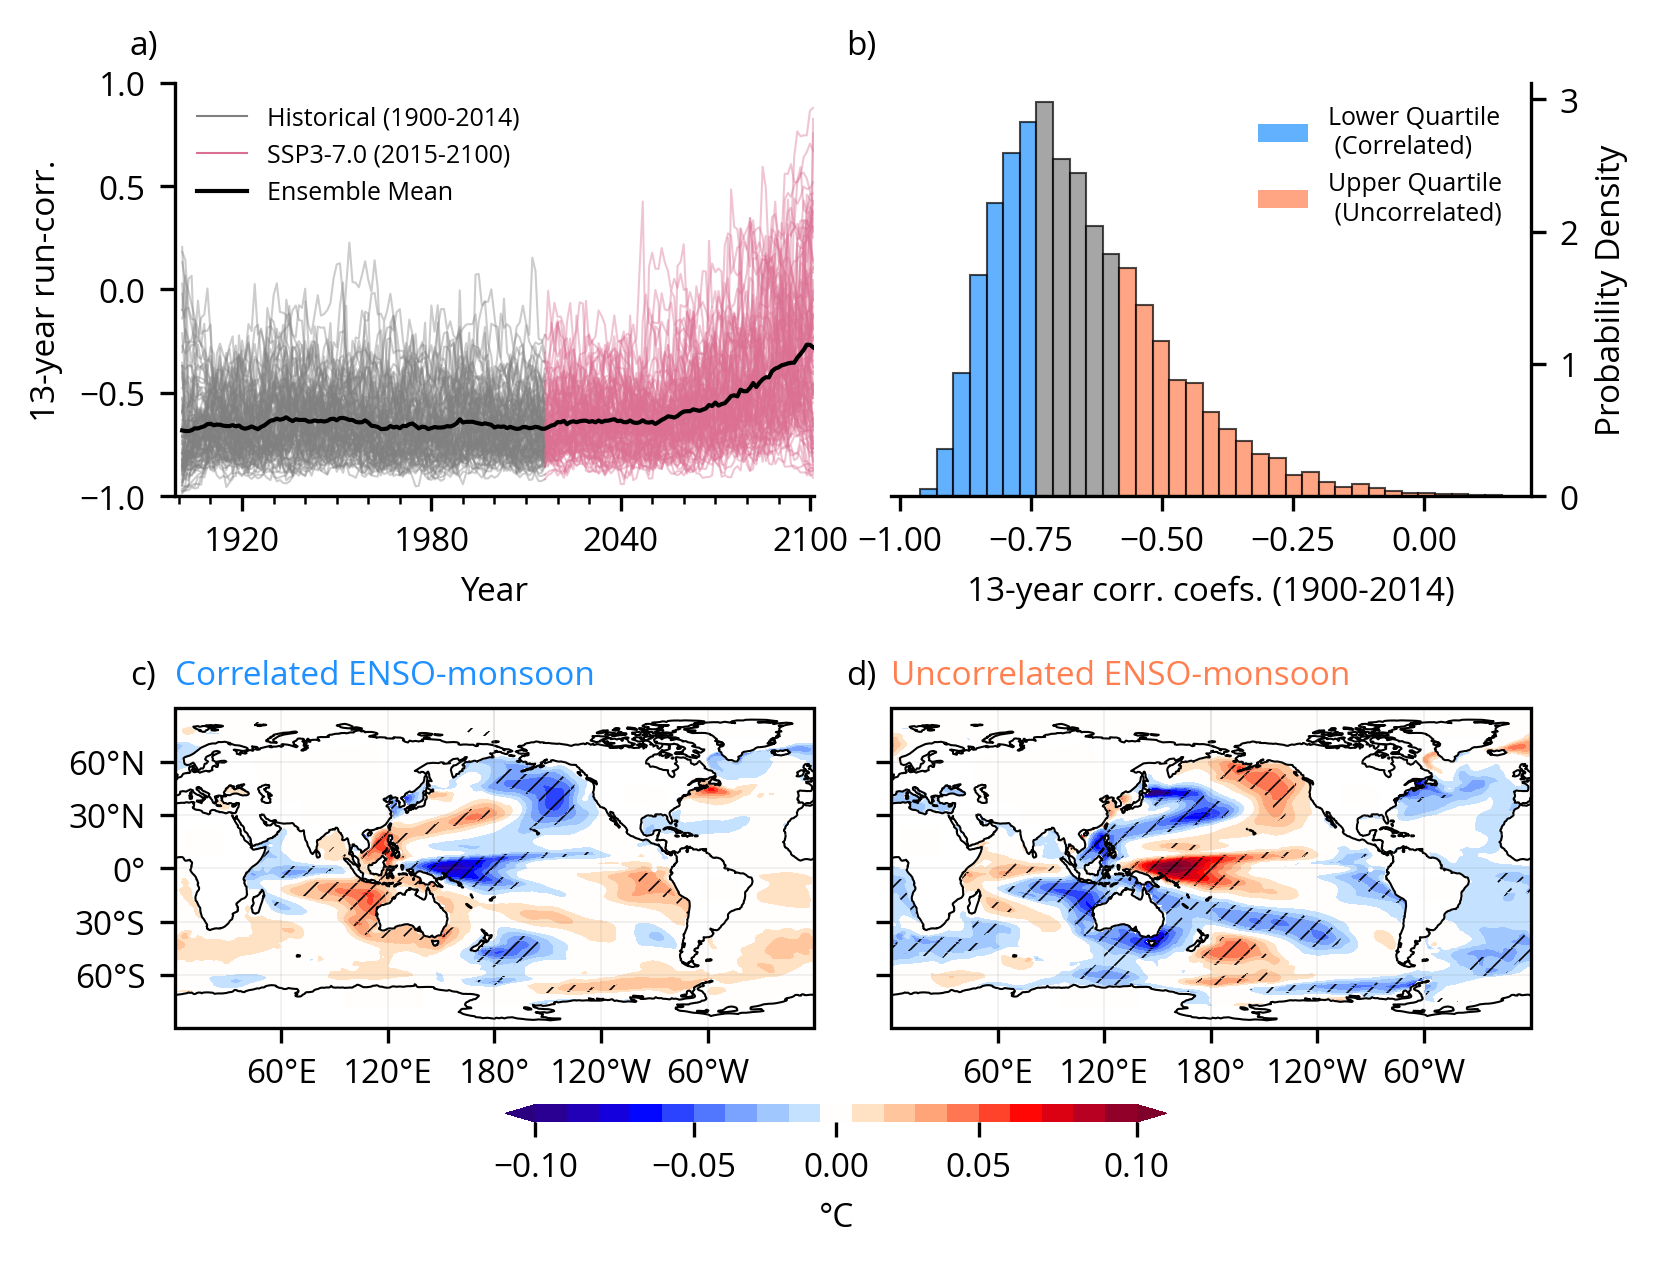

In [23]:
utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 2, top=0.94, bottom=0.10, left=0.1, right=0.92, hspace=0.4, wspace=0.12)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 2a ##############
ax1 = plots.plot_runcorr_cesm_timeseries(cesm_correlations_da, ax1)

############## Figure 2b ##############
data = random_13yr_periods_df.Correlations
ax2 = plots.draw_pdf(data, ax2, xlabel='13-year corr. coefs. (1900-2014)')

############## Figure 2c ##############
levels = [-.10, -0.09, -.08, -0.07, -.06, -0.05, -.04,-0.03, -.02, -0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
ticks=[-0.1, -0.05, 0, 0.05, 0.1]

lower_sst_da_difference_da.sel(lon=320, method='nearest')[:] = lower_sst_da_difference_da.sel(lon=321, method='nearest')
im = plots.draw_quartile_anomalies(lower_sst_da_difference_da, fig, ax3, lower_pvals, 
                    vmin=-0.10, vmax=0.10, 
                    levels=levels,
                    ticks=ticks,
                    cmap=cmaps.NCV_blu_red)
                    
ax3.set_yticklabels([-60, -30, 0, 30, 60],fontsize=8)
lat_formatter = LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)

############## Figure 2d ##############
upper_sst_difference_da.sel(lon=320, method='nearest')[:] = upper_sst_difference_da.sel(lon=321, method='nearest')
im = plots.draw_quartile_anomalies(upper_sst_difference_da, fig, ax4, upper_pvals, 
                    vmin=-0.10, vmax=0.10, 
                    levels=levels,
                    ticks=ticks,
                    cmap=cmaps.NCV_blu_red)
ax4.set_yticklabels([])

# Set subplot labels
titles1 = ["a)", "b)", "c)", "d)"]
titles2 = [None, None, "Correlated ENSO-monsoon", "Uncorrelated ENSO-monsoon"]
colors = ['k', 'k', 'dodgerblue', 'coral']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3, ax4], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

# Add colorbar
cbar_ax = fig.add_axes([0.3, 0.06, 0.4, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-.1, -.05, 0, .05, .1], label="°C", orientation="horizontal", shrink=0.50)
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)

plt.savefig("Fig2.png")
plt.savefig("Fig2.pdf")